In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.photUtils import Sed, Bandpass
from shape_metric import Size_precision_metric, Systematic_angle_metric

In [2]:
dbFile = 'baseline_nexp2_v1.7_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

## Shape Precision metric

The `Size_precision_metric` computes the SNR one would have measuring the shape of an extragalactic object (i.e., one that has suffered extinction). It uses a rather simple recipe for computing the uncertainty in a mesured FWHM from Lenz et al 1992. While there are some obvious simplifications (galaxies are two dimensional on the image and not shapped like Gaussians), the relative scaling with observation metadata should be correct.

The default parameters assume an object with:
* FWHM = 3 arcseconds
* an unextincted central surface brightness of 19 mag/sq arcsec in g, r, and i
* That there is a nearby star with ~5000 counts in it's peak to measure the image PSF FWHM from
* A platescale of 0.2 arcsec/pixel

We can change these to more accurately represent real galaxies of interest.

A potential additional cut can be added to demand the stellar density be below a threshold value.

This metric has the potential to be summerized by the total area that reaches some specified SNR ratio. 

In [3]:
bundleList = []
sql = ''
metric = Size_precision_metric()
slicer = slicers.HealpixSlicer(useCache=False)
summaryStats = []
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with no constraint for columns ['airmass', 'seeingFwhmGeom', 'skyBrightness', 'fieldDec', 'filter', 'fieldRA', 'fiveSigmaDepth', 'visitExposureTime'].
Found 2045493 visits
Running:  ['opsim_SizePrecision_HEAL']


/Users/yoachim/git_repos/21_Scratch/shape_metric/shape_metric.py:104: RuntimeWarning: divide by zero encountered in true_divide
  sigma_fwhm_object_predeconv = 1.4*fwhm_observed*(self.pixscale/fwhm_observed)**0.5*noise_at_peak/peak_counts
/Users/yoachim/git_repos/21_Scratch/shape_metric/shape_metric.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  result = self.fwhm_object/np.sum(1./sigma_fwhm_object**2)**-0.5
/Users/yoachim/git_repos/21_Scratch/shape_metric/shape_metric.py:107: RuntimeWarning: overflow encountered in square
  sigma_fwhm_object = (sigma_fwhm_object_predeconv**2 + sigma_fwhm_refstar**2)**0.5


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "" constraint now.


/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:106: UserWarning: Optimal bin calculation tried to make 267 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 437.123  dipole: lon: 49.6346, lat: -59.0345, amp: 123.375
  warnings.warn(


Plotting complete.


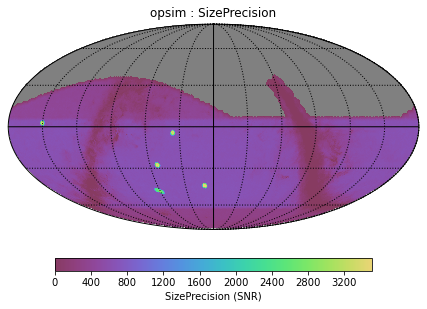

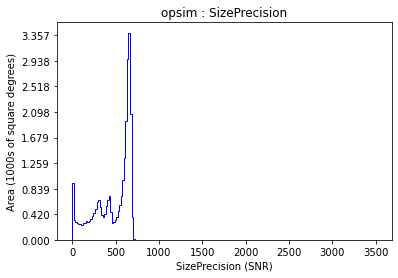

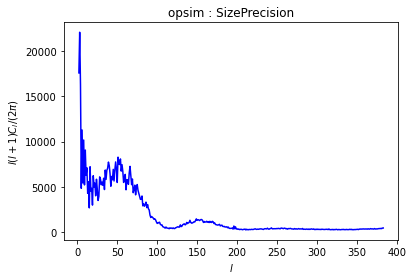

In [4]:
bg.plotAll(closefigs=False)

/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:9

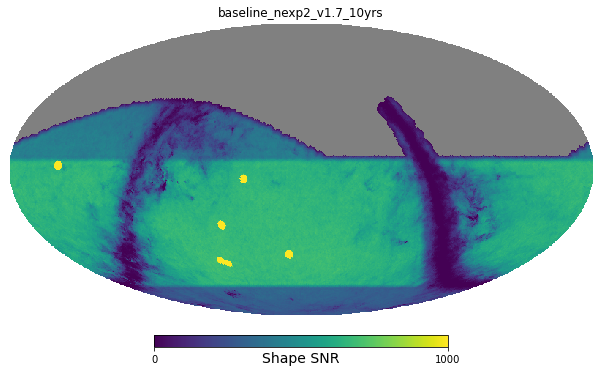

In [5]:
# Manually plotting to adjust the stretch a bit. 
# We can see the DDFs have very high SNR, as expected, while the MW dust extinction clearly lowers the SNR.
hp.mollview(bundleList[0].metricValues, max=1000, unit='Shape SNR', title=dbFile.replace('.db',''))

## Averaging out of a systematic distortion

The `Systematic_angle_metric` assumes there is a systematic distortion in shape measurements along one axis. The default settings are to have the distortion be at the 10% level, and to check 30 potential distortion directions. We use the SNR for each observation calculated from `Size_precision_metric` to compute the weighted mean shape one would calculate if there was no correction for the systematics and return the mean residual. If there is no angular dithering, the mean residual should be the same as the input. In the case of infinite observations perfectly dithered, the metric will go to zero. 

For the examples below, we check just the observations in r. We also run checking for how well distortions are removed averaging over rotSkyPos (the direction of North on the focal plane), and averaging over rotTelPos (the amount the camera has been physically rotated). The angles are modulated by 180 degrees by default.

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint filter="r" for columns ['airmass', 'seeingFwhmGeom', 'skyBrightness', 'rotTelPos', 'rotSkyPos', 'fieldDec', 'filter', 'fieldRA', 'fiveSigmaDepth', 'visitExposureTime']
Found 452001 visits
Running:  ['opsim_AngularSysrotTel_r_HEAL', 'opsim_AngularSysrotSky_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r"" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:106: UserWarning: Optimal bin calculation tried to make 1365 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 0.0118515  dipole: lon: -106.536, lat: 70.6276, amp: 0.00118608
  warnings.warn(
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:106: UserWarning: Optimal bin calculation tried to make 1663 bins, returning 20

Plotting complete.


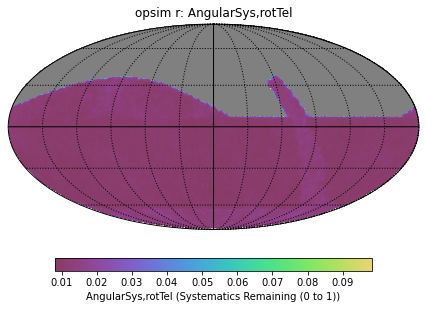

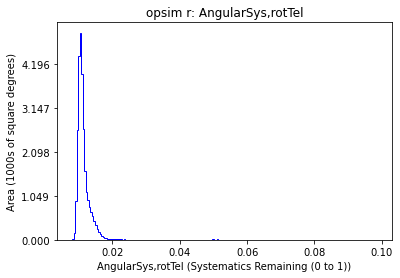

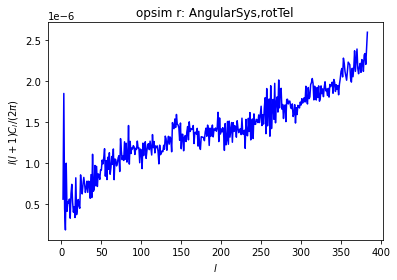

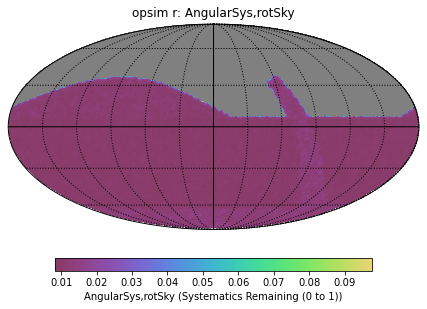

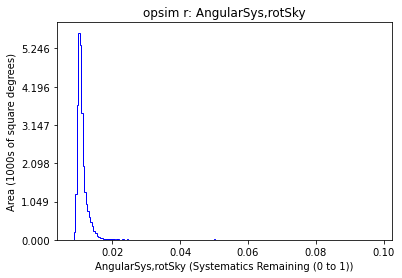

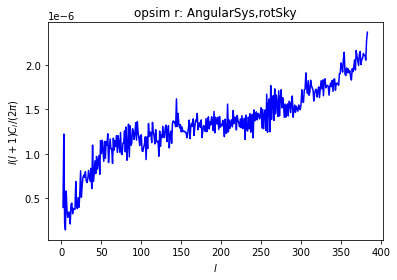

In [6]:
bundleList = []
# systematics should probably be per filter?
sql = 'filter="r"'
metric = Systematic_angle_metric(angleCol='rotTelPos', metricName='AngularSys,rotTel')
slicer = slicers.HealpixSlicer(useCache=False)
summaryStats = []
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))
metric = Systematic_angle_metric(angleCol='rotSkyPos', metricName='AngularSys,rotSky')
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))


bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:9

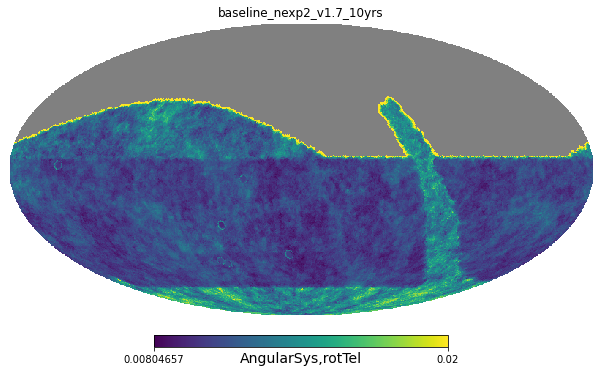

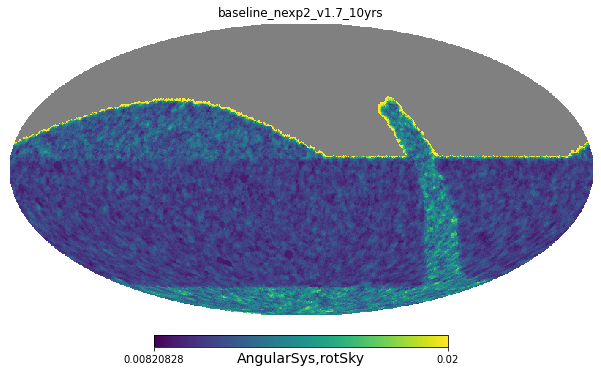

In [7]:
# Once again, replotting to adjust the stretch.  In the baseline, for both rotTelPos and rotSkyPos, the mean 
# shape residual from systematics is reduced from 10% to ~1%. WFD regions recieve ~190 observations in r,
# so this seems to make sense that in our default scheme of random rotational dithering systematics should 
# decrease by a factor of ~1/sqrt(N).

hp.mollview(bundleList[0].metricValues, max=0.02,title=dbFile.replace('.db',''), unit=bundleList[0].metric.name)
hp.mollview(bundleList[1].metricValues, max=0.02,title=dbFile.replace('.db',''), unit=bundleList[1].metric.name)


## Checking angular systematics in the spiders simulation

In this simulation, the camera was rotated to keep stellar diffraction spikes along CCD rows and columns. We can see that while systematics in rotSkyPos are decreased similarly to before, the systematics in rotTelPos are not as well removed. 

In [8]:
dbFile = 'spiders_v1.5_10yrs.db'
conn = db.OpsimDatabase(dbFile)
bundleList = []
sql = 'filter="r"'
metric = Systematic_angle_metric(angleCol='rotTelPos', metricName='AngularSys,rotTel')
slicer = slicers.HealpixSlicer(useCache=False)
summaryStats = []
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
#bg.plotAll(closefigs=False)


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint filter="r" for columns ['airmass', 'seeingFwhmGeom', 'skyBrightness', 'rotTelPos', 'fieldDec', 'filter', 'fieldRA', 'fiveSigmaDepth', 'visitExposureTime']
Found 492318 visits
Running:  ['opsim_AngularSysrotTel_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


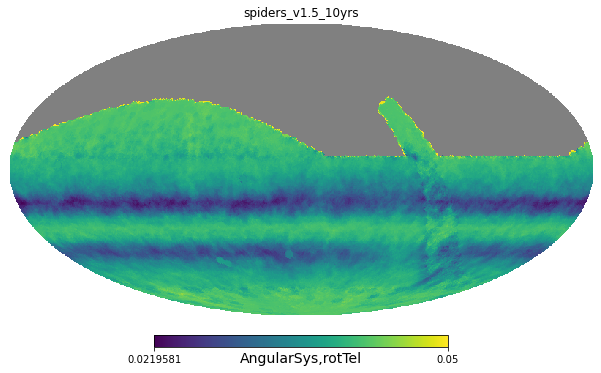

In [9]:
hp.mollview(bundleList[0].metricValues, max=.05,title=dbFile.replace('.db',''), unit=bundleList[0].metric.name)

In [ ]:
dbFile = 'spiders_v1.5_10yrs.db'
conn = db.OpsimDatabase(dbFile)
bundleList = []
sql = 'filter="r"'
metric = Systematic_angle_metric(angleCol='rotSkyPos', metricName='AngularSys,rotSky')
slicer = slicers.HealpixSlicer(useCache=False)
summaryStats = []
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
#bg.plotAll(closefigs=False)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint filter="r" for columns ['airmass', 'seeingFwhmGeom', 'skyBrightness', 'rotSkyPos', 'fieldDec', 'filter', 'fieldRA', 'fiveSigmaDepth', 'visitExposureTime']
Found 492318 visits
Running:  ['opsim_AngularSysrotSky_r_HEAL']


In [ ]:
#hp.mollview(bundleList[0].metricValues, max=.015)
hp.mollview(bundleList[0].metricValues, max=.02,title=dbFile.replace('.db',''), unit=bundleList[0].metric.name)

General intuitive checks of a weak lensing metric

* if the atmospheric seeing gets better, metric should get better
* if images are deeper, metric should get better
* if there are more observations of similar quality, metric should get better
* if we use a brighter fiducial object, metric should get better
* if we observe a region of sky with less dust, metric should get better